# WEB

In [274]:
import psutil
import zipfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from scipy.stats import entropy
from collections import Counter
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN, HDBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
import tree_sitter_php as tsphp
from tree_sitter import Language, Parser, Tree

## 0 Current RAM usage monitoring

In [2]:
def get_ram_usage():
    memory_info = psutil.Process().memory_info()
    return memory_info.rss / (1024 * 1024 * 1024)
print(f"Current RAM usage: {get_ram_usage():.2f} / 24 GB ({get_ram_usage()/24*100:.1f} %)")

Current RAM usage: 0.17 / 24 GB (0.7 %)


## 1. Data preprocessing

### 1.1 Get data and extract features

In [157]:
def get_distribution(l, bins):
    """
    Given a list of entropies, returns its distribution in [0.0, 6.0] (with a step of 0.2)
    """
    if l != []:
        counts, _ = np.histogram(l, bins=bins, density=True) 
    else:
        counts = bins[:-1]*0.0 
    return counts / 5

def compute_entropy(string):
    """
    Computes the entropy of a string, in base 2
    """
    freq = Counter(string)
    return entropy(list(freq.values()), base=2)

def read_file_web(path):
    """
    Read a web file
    Returns a string of the decoded file
    """
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        webfile = f.read()
        return webfile

def get_node_depth(node):
    """
    Get the depth of a node
    """
    if node.child_count == 0:
        return 0
    else:
        return 1 + max(get_node_depth(node.child(i)) for i in range(node.child_count))

def traverse_tree(tree: Tree, max_text_length=100, handcrafted_features: list = None):
    """
    Walk along the whole treeSitter.Tree in a prefix way.
    Returns the type of each node, and if possible its text and the entropy of the text
    node_types: big string (each type separated by a ' ')
    node_texts: big string (each text separated by a ' ')
    entropies: list
    """
    cursor = tree.walk()
    node_types, node_texts, entropies = '', '', []
    visited_children = False
    
    while True:
        if not visited_children:
            # text = text if (cursor.node.text and cursor.node.type == 'string_content' and compute_entropy(text.decode()) > 5) else b''
            text = cursor.node.text
            node_types += cursor.node.type + ' '
            if cursor.node.type == 'string_content' and cursor.node.text:
                entropies += [min(6, compute_entropy(text.decode()))]            
            if not cursor.goto_first_child():
                visited_children = True
        elif cursor.goto_next_sibling():
            visited_children = False
        elif not cursor.goto_parent():
            break

    return node_types, entropies

def web_files_generator(web_filenames_train, node_types_list, entropy_array, bins=np.linspace(0, 6, 31), train=True):
    print(f'Number of web files: {len(web_filenames_train)}')
    PHP_LANGUAGE = Language(tsphp.language_php())
    parser = Parser(PHP_LANGUAGE)
    
    for i, filename in enumerate(web_filenames_train):
        if get_ram_usage() > 10:
            print(f"DANGER! Current RAM usage: {get_ram_usage():.2f} / 24 GB ({get_ram_usage()/24*100:.1f} %)")
            break
        if train:
            labels_train[i] = filename[-1]
        
        webfile = read_file_web(filename)
        tree = parser.parse(bytes(webfile, encoding='utf-8'), encoding='utf-8')

        node_types, entropies = traverse_tree(tree)
        entropy_distribution = get_distribution(entropies, bins=bins)

        assert entropy_array[i,:].shape == entropy_distribution.shape, f"entropy_array[i] and entropy_distribution have different shapes, {entropy_distribution = }"
        node_types_list += [node_types]
        entropy_array[i] = entropy_distribution
        
        if i % 100 == 0:
            print(f"iter {i:3d} done  |  Current RAM usage: {get_ram_usage():.2f} / 24 GB ({get_ram_usage()/24*100:.1f} %)")
    
# web_filenames_train = zipfile.ZipFile('php-train.zip').namelist()[:-1]
# bins = np.linspace(0, 6, 31)
# n = 3

# labels_train = np.zeros(len(web_filenames_train), dtype=int)
# node_types_list, entropy_array = [], np.zeros((len(web_filenames_train), len(bins)-1), dtype=float)

# web_files_generator(web_filenames_train, node_types_list, entropy_array, bins=bins)
# vectorizer_type = CountVectorizer(strip_accents='unicode', ngram_range=(n,n), analyzer='word', min_df=5)
# features_type_train = vectorizer_type.fit_transform(node_types_list).toarray()

# features_train = np.concatenate((features_type_train, entropy_array), axis=1)
# print(f'{features_train.shape = }')

In [ ]:
##### PCA on features_train #####

def mypca(features_train, nb_dim=2):
    # Standardize 
    scaler_train = PowerTransformer()
    features_scaled_train = scaler_train.fit_transform(features_train)
    # PCA over first nb_dim dimensions
    pca_train = PCA(n_components=nb_dim, random_state=0)
    features_pca_train = pca_train.fit_transform(features_scaled_train)
    print(f'{features_pca_train.shape = }')
    # Plot over first 2 dimensions
    plt.scatter(features_pca_train[:,0], features_pca_train[:,1], alpha=.4)
    _ = plt.title(f'features_pca_train with {nb_dim} dim°')
    return features_pca_train

features_pca_2_train = mypca(features_train, 2)

features_pca_10_train = mypca(features_train, 10)

features_pca_50_train = mypca(features_train, 50)

In [ ]:

# labels_train[features_pca_train[:,0] < -25], labels_train[features_pca_train[:,0] > 30], labels_train[(15 < features_pca_train[:,0]) * (features_pca_train[:,0] < 25)], labels_train[(0 < features_pca_train[:,0]) * (features_pca_train[:,0] < 15)], labels_train[features_pca_train[:,1] > 100]


### 1.2 Save/load data 

In [41]:
# np.save('features_train2.npy', features_train)
# np.save('labels_train2.npy', labels_train)
features_train = np.load('features_train2.npy')
labels_train = np.load('labels_train2.npy')
print(f'{features_train.shape = }, {labels_train.shape = }')

features_train.shape = (657, 2628), labels_train.shape = (657,)


## 2. Select and train model

### 2.0 K-fold cross-validation

In [164]:
def train_evaluate(model, features, labels, model_name='base-model', n_splits=5, fit_whole_dataset=False, train=True):
    X_train = features
    y_pred = model.fit_predict(X_train)
    # Evaluate 
    silhouette = silhouette_score(X_train, y_pred)
    print(f'{model_name}: Silhouette score = {silhouette:.3f}')
    if train:    
        ars = adjusted_rand_score(labels, y_pred)
        print(f'{model_name}: ARS = {ars:.3f}')

### 2.1 KMeans

In [148]:
for nb_clusters in range(2, 10):
    print(f'{nb_clusters = }')
    km_model = MiniBatchKMeans(n_clusters=nb_clusters, batch_size=64, random_state=0, n_init=5)
    _ = train_evaluate(km_model, features_pca_2_train, labels_train, model_name='KMeans(4, 64)', n_splits=5, fit_whole_dataset=False)
    print('')

nb_clusters = 2
KMeans(4, 64): Silhouette score = 0.779
KMeans(4, 64): ARS = -0.096

nb_clusters = 3
KMeans(4, 64): Silhouette score = 0.832
KMeans(4, 64): ARS = 0.022

nb_clusters = 4
KMeans(4, 64): Silhouette score = 0.818
KMeans(4, 64): ARS = 0.312

nb_clusters = 5
KMeans(4, 64): Silhouette score = 0.794
KMeans(4, 64): ARS = 0.267

nb_clusters = 6
KMeans(4, 64): Silhouette score = 0.827
KMeans(4, 64): ARS = 0.272

nb_clusters = 7
KMeans(4, 64): Silhouette score = 0.745
KMeans(4, 64): ARS = 0.227

nb_clusters = 8
KMeans(4, 64): Silhouette score = 0.544
KMeans(4, 64): ARS = 0.100

nb_clusters = 9
KMeans(4, 64): Silhouette score = 0.491
KMeans(4, 64): ARS = 0.079



In [149]:
for nb_clusters in range(2, 10):
    print(f'{nb_clusters = }')
    km_model = MiniBatchKMeans(n_clusters=nb_clusters, batch_size=64, random_state=0, n_init=5)
    _ = train_evaluate(km_model, features_pca_10_train, labels_train, model_name='KMeans(4, 64)', n_splits=5, fit_whole_dataset=False)
    print('')

nb_clusters = 2
KMeans(4, 64): Silhouette score = 0.532
KMeans(4, 64): ARS = -0.112

nb_clusters = 3
KMeans(4, 64): Silhouette score = 0.580
KMeans(4, 64): ARS = 0.270

nb_clusters = 4
KMeans(4, 64): Silhouette score = 0.590
KMeans(4, 64): ARS = 0.266

nb_clusters = 5
KMeans(4, 64): Silhouette score = 0.621
KMeans(4, 64): ARS = 0.302

nb_clusters = 6
KMeans(4, 64): Silhouette score = 0.640
KMeans(4, 64): ARS = 0.300

nb_clusters = 7
KMeans(4, 64): Silhouette score = 0.659
KMeans(4, 64): ARS = 0.229

nb_clusters = 8
KMeans(4, 64): Silhouette score = 0.515
KMeans(4, 64): ARS = 0.115

nb_clusters = 9
KMeans(4, 64): Silhouette score = 0.519
KMeans(4, 64): ARS = 0.055



In [150]:
for nb_clusters in range(2, 10):
    print(f'{nb_clusters = }')
    km_model = MiniBatchKMeans(n_clusters=nb_clusters, batch_size=64, random_state=0, n_init=5)
    _ = train_evaluate(km_model, features_pca_50_train, labels_train, model_name='KMeans(4, 64)', n_splits=5, fit_whole_dataset=False)
    print('')

nb_clusters = 2
KMeans(4, 64): Silhouette score = 0.404
KMeans(4, 64): ARS = -0.112

nb_clusters = 3
KMeans(4, 64): Silhouette score = 0.421
KMeans(4, 64): ARS = 0.270

nb_clusters = 4
KMeans(4, 64): Silhouette score = 0.457
KMeans(4, 64): ARS = -0.038

nb_clusters = 5
KMeans(4, 64): Silhouette score = 0.277
KMeans(4, 64): ARS = 0.158

nb_clusters = 6
KMeans(4, 64): Silhouette score = 0.177
KMeans(4, 64): ARS = -0.021

nb_clusters = 7
KMeans(4, 64): Silhouette score = 0.485
KMeans(4, 64): ARS = 0.315

nb_clusters = 8
KMeans(4, 64): Silhouette score = 0.270
KMeans(4, 64): ARS = 0.144

nb_clusters = 9
KMeans(4, 64): Silhouette score = 0.318
KMeans(4, 64): ARS = 0.048



### 2.2 HDBSCAN

In [117]:
for cs in range(2, 40): 
    hdbscan_model = HDBSCAN(min_cluster_size=cs)
    _ = train_evaluate(hdbscan_model, features_pca_2_train, labels_train, model_name=f'HDBSCAN(min_cluster_size={cs})', n_splits=5, fit_whole_dataset=True)
    print('')

HDBSCAN(min_cluster_size=2): Silhouette score = 0.461
HDBSCAN(min_cluster_size=2): ARS = 0.006

HDBSCAN(min_cluster_size=3): Silhouette score = 0.366
HDBSCAN(min_cluster_size=3): ARS = 0.019

HDBSCAN(min_cluster_size=4): Silhouette score = 0.290
HDBSCAN(min_cluster_size=4): ARS = 0.026

HDBSCAN(min_cluster_size=5): Silhouette score = 0.353
HDBSCAN(min_cluster_size=5): ARS = 0.024

HDBSCAN(min_cluster_size=6): Silhouette score = 0.362
HDBSCAN(min_cluster_size=6): ARS = 0.030

HDBSCAN(min_cluster_size=7): Silhouette score = 0.344
HDBSCAN(min_cluster_size=7): ARS = 0.026

HDBSCAN(min_cluster_size=8): Silhouette score = 0.400
HDBSCAN(min_cluster_size=8): ARS = 0.020

HDBSCAN(min_cluster_size=9): Silhouette score = 0.413
HDBSCAN(min_cluster_size=9): ARS = 0.024

HDBSCAN(min_cluster_size=10): Silhouette score = 0.420
HDBSCAN(min_cluster_size=10): ARS = 0.021

HDBSCAN(min_cluster_size=11): Silhouette score = 0.378
HDBSCAN(min_cluster_size=11): ARS = 0.025

HDBSCAN(min_cluster_size=12): Silhou

In [118]:
for cs in range(2, 40): 
    hdbscan_model = HDBSCAN(min_cluster_size=cs)
    _ = train_evaluate(hdbscan_model, features_pca_10_train, labels_train, model_name=f'HDBSCAN(min_cluster_size={cs})', n_splits=5, fit_whole_dataset=True)
    print('')

HDBSCAN(min_cluster_size=2): Silhouette score = 0.375
HDBSCAN(min_cluster_size=2): ARS = 0.008

HDBSCAN(min_cluster_size=3): Silhouette score = 0.240
HDBSCAN(min_cluster_size=3): ARS = -0.002

HDBSCAN(min_cluster_size=4): Silhouette score = 0.336
HDBSCAN(min_cluster_size=4): ARS = 0.007

HDBSCAN(min_cluster_size=5): Silhouette score = 0.231
HDBSCAN(min_cluster_size=5): ARS = 0.007

HDBSCAN(min_cluster_size=6): Silhouette score = 0.261
HDBSCAN(min_cluster_size=6): ARS = 0.013

HDBSCAN(min_cluster_size=7): Silhouette score = 0.341
HDBSCAN(min_cluster_size=7): ARS = 0.015

HDBSCAN(min_cluster_size=8): Silhouette score = 0.433
HDBSCAN(min_cluster_size=8): ARS = 0.018

HDBSCAN(min_cluster_size=9): Silhouette score = 0.393
HDBSCAN(min_cluster_size=9): ARS = 0.020

HDBSCAN(min_cluster_size=10): Silhouette score = 0.548
HDBSCAN(min_cluster_size=10): ARS = 0.039

HDBSCAN(min_cluster_size=11): Silhouette score = 0.547
HDBSCAN(min_cluster_size=11): ARS = 0.038

HDBSCAN(min_cluster_size=12): Silho

In [119]:
for cs in range(2, 40): 
    hdbscan_model = HDBSCAN(min_cluster_size=cs)
    _ = train_evaluate(hdbscan_model, features_pca_50_train, labels_train, model_name=f'HDBSCAN(min_cluster_size={cs})', n_splits=5, fit_whole_dataset=True)
    print('')

HDBSCAN(min_cluster_size=2): Silhouette score = 0.376
HDBSCAN(min_cluster_size=2): ARS = 0.012

HDBSCAN(min_cluster_size=3): Silhouette score = 0.367
HDBSCAN(min_cluster_size=3): ARS = 0.008

HDBSCAN(min_cluster_size=4): Silhouette score = 0.344
HDBSCAN(min_cluster_size=4): ARS = 0.018

HDBSCAN(min_cluster_size=5): Silhouette score = 0.259
HDBSCAN(min_cluster_size=5): ARS = 0.010

HDBSCAN(min_cluster_size=6): Silhouette score = 0.276
HDBSCAN(min_cluster_size=6): ARS = 0.005

HDBSCAN(min_cluster_size=7): Silhouette score = 0.304
HDBSCAN(min_cluster_size=7): ARS = 0.011

HDBSCAN(min_cluster_size=8): Silhouette score = 0.366
HDBSCAN(min_cluster_size=8): ARS = 0.004

HDBSCAN(min_cluster_size=9): Silhouette score = 0.371
HDBSCAN(min_cluster_size=9): ARS = 0.001

HDBSCAN(min_cluster_size=10): Silhouette score = 0.403
HDBSCAN(min_cluster_size=10): ARS = -0.001

HDBSCAN(min_cluster_size=11): Silhouette score = 0.470
HDBSCAN(min_cluster_size=11): ARS = 0.008

HDBSCAN(min_cluster_size=12): Silho

### 2.5 DBSCAN

In [185]:
for eps in range(5, 6):
    for ms in range(1, 40): # ms=4
        print(f'{eps=}, {ms=}')
        dbscan_model = DBSCAN(eps=eps, min_samples=ms)
        try:
            _ = train_evaluate(dbscan_model, features_pca_2_train, labels_train, model_name=f'DBSCAN(min_samples={ms})', n_splits=5, fit_whole_dataset=True)
        except ValueError:
            print('ValueError')
        print('')

eps=5, ms=1
DBSCAN(min_samples=1): Silhouette score = 0.788
DBSCAN(min_samples=1): ARS = 0.315

eps=5, ms=2
DBSCAN(min_samples=2): Silhouette score = 0.788
DBSCAN(min_samples=2): ARS = 0.315

eps=5, ms=3
DBSCAN(min_samples=3): Silhouette score = 0.807
DBSCAN(min_samples=3): ARS = 0.315

eps=5, ms=4
DBSCAN(min_samples=4): Silhouette score = 0.825
DBSCAN(min_samples=4): ARS = 0.314

eps=5, ms=5
DBSCAN(min_samples=5): Silhouette score = 0.825
DBSCAN(min_samples=5): ARS = 0.314

eps=5, ms=6
DBSCAN(min_samples=6): Silhouette score = 0.825
DBSCAN(min_samples=6): ARS = 0.314

eps=5, ms=7
DBSCAN(min_samples=7): Silhouette score = 0.825
DBSCAN(min_samples=7): ARS = 0.314

eps=5, ms=8
DBSCAN(min_samples=8): Silhouette score = 0.823
DBSCAN(min_samples=8): ARS = 0.313

eps=5, ms=9
DBSCAN(min_samples=9): Silhouette score = 0.823
DBSCAN(min_samples=9): ARS = 0.313

eps=5, ms=10
DBSCAN(min_samples=10): Silhouette score = 0.823
DBSCAN(min_samples=10): ARS = 0.313

eps=5, ms=11
DBSCAN(min_samples=11): 

In [155]:
for ms in range(2, 20): # ms=4
    print(ms)
    dbscan_model = DBSCAN(min_samples=ms)
    try:
        _ = train_evaluate(dbscan_model, features_pca_10_train, labels_train, model_name=f'DBSCAN(min_samples={ms})', n_splits=5, fit_whole_dataset=True)
    except ValueError:
        print('ValueError')
    print('')

2
DBSCAN(min_samples=2): Silhouette score = 0.565
DBSCAN(min_samples=2): ARS = 0.051

3
DBSCAN(min_samples=3): Silhouette score = 0.475
DBSCAN(min_samples=3): ARS = 0.029

4
DBSCAN(min_samples=4): Silhouette score = 0.472
DBSCAN(min_samples=4): ARS = 0.027

5
DBSCAN(min_samples=5): Silhouette score = 0.398
DBSCAN(min_samples=5): ARS = 0.007

6
DBSCAN(min_samples=6): Silhouette score = 0.374
DBSCAN(min_samples=6): ARS = -0.010

7
DBSCAN(min_samples=7): Silhouette score = 0.365
DBSCAN(min_samples=7): ARS = -0.020

8
DBSCAN(min_samples=8): Silhouette score = 0.344
DBSCAN(min_samples=8): ARS = -0.032

9
DBSCAN(min_samples=9): Silhouette score = 0.292
DBSCAN(min_samples=9): ARS = -0.056

10
DBSCAN(min_samples=10): Silhouette score = 0.275
DBSCAN(min_samples=10): ARS = -0.076

11
DBSCAN(min_samples=11): Silhouette score = 0.261
DBSCAN(min_samples=11): ARS = -0.094

12
DBSCAN(min_samples=12): Silhouette score = 0.293
DBSCAN(min_samples=12): ARS = -0.109

13
DBSCAN(min_samples=13): Silhouette 

In [156]:
for ms in range(2, 20): # ms=4
    print(ms)
    dbscan_model = DBSCAN(min_samples=ms)
    try:
        _ = train_evaluate(dbscan_model, features_pca_50_train, labels_train, model_name=f'DBSCAN(min_samples={ms})', n_splits=5, fit_whole_dataset=True)
    except ValueError:
        print('ValueError')
    print('')

2
DBSCAN(min_samples=2): Silhouette score = 0.280
DBSCAN(min_samples=2): ARS = -0.011

3
DBSCAN(min_samples=3): Silhouette score = 0.092
DBSCAN(min_samples=3): ARS = -0.051

4
DBSCAN(min_samples=4): Silhouette score = -0.076
DBSCAN(min_samples=4): ARS = -0.044

5
DBSCAN(min_samples=5): Silhouette score = -0.175
DBSCAN(min_samples=5): ARS = -0.028

6
DBSCAN(min_samples=6): Silhouette score = -0.202
DBSCAN(min_samples=6): ARS = -0.062

7
DBSCAN(min_samples=7): Silhouette score = -0.230
DBSCAN(min_samples=7): ARS = -0.088

8
DBSCAN(min_samples=8): Silhouette score = -0.264
DBSCAN(min_samples=8): ARS = -0.068

9
DBSCAN(min_samples=9): Silhouette score = -0.331
DBSCAN(min_samples=9): ARS = -0.072

10
DBSCAN(min_samples=10): Silhouette score = -0.336
DBSCAN(min_samples=10): ARS = -0.129

11
DBSCAN(min_samples=11): Silhouette score = -0.336
DBSCAN(min_samples=11): ARS = -0.129

12
DBSCAN(min_samples=12): Silhouette score = -0.346
DBSCAN(min_samples=12): ARS = -0.115

13
DBSCAN(min_samples=13)

### 2.3 Spectral Clustering

In [102]:
#SpectralClustering(n_clusters=8, *, eigen_solver=None, n_components=None, random_state=None, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol='auto', assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None, verbose=False)

sc_model = SpectralClustering(n_clusters=5, n_init=20)
%time _ = train_evaluate(sc_model, features_pca_train, labels_train, model_name='SC()', n_splits=5, fit_whole_dataset=True)

/home/stud09/env/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SC(): Silhouette score = 0.875
SC(): ARS = 0.011
CPU times: user 49.6 s, sys: 1min 54s, total: 2min 43s
Wall time: 16.4 s


/home/stud09/env/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


### 2.4 Gaussian Mixture

In [100]:
#GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
gm_model = GaussianMixture()
%time _ = train_evaluate(gm_model, features_pca_train.astype(int), labels_train, model_name='GM()', n_splits=5, fit_whole_dataset=True)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## 3. Predict on test dataset

In [158]:
##### Extract features on test dataset #####

web_filenames_test = zipfile.ZipFile('php-test.zip').namelist()
bins = np.linspace(0, 6, 31)
n = 3

node_types_list_test, entropy_array_test = [], np.zeros((len(web_filenames_test), len(bins)-1), dtype=float)

web_files_generator(web_filenames_test, node_types_list_test, entropy_array_test, bins=bins, train=False)
features_type_test = vectorizer_type.fit_transform(node_types_list_test).toarray()

features_test = np.concatenate((features_type_test, entropy_array_test), axis=1)
print(f'{features_test.shape = }')

Number of web files: 355
iter   0 done  |  Current RAM usage: 1.83 / 24 GB (7.6 %)
iter 100 done  |  Current RAM usage: 1.83 / 24 GB (7.6 %)
iter 200 done  |  Current RAM usage: 1.83 / 24 GB (7.6 %)
iter 300 done  |  Current RAM usage: 1.83 / 24 GB (7.6 %)
features_test.shape = (355, 1794)


features_pca_train.shape = (355, 2)
features_pca_train.shape = (355, 10)
features_pca_train.shape = (355, 50)


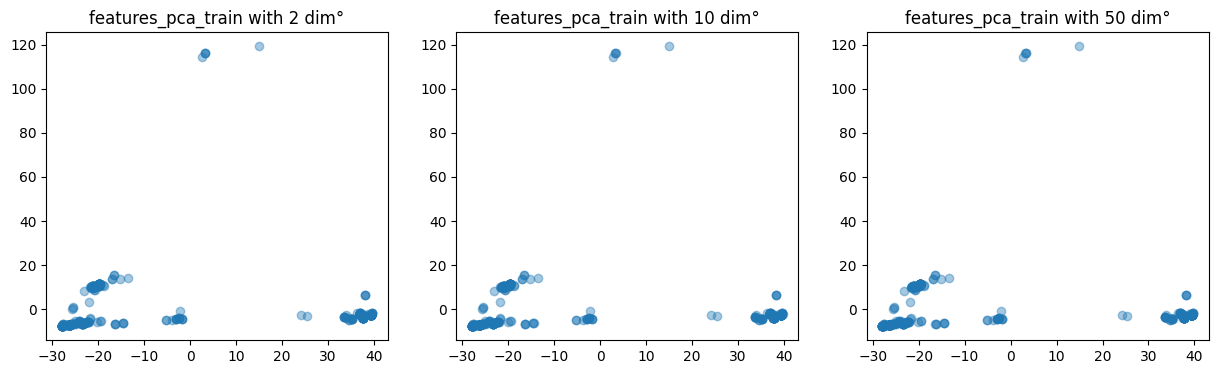

In [162]:
##### PCA on features_train #####

def mypca(features, nb_dim=2):
    # Standardize 
    scaler_train = PowerTransformer()
    features_scaled_train = scaler_train.fit_transform(features)
    # PCA over first nb_dim dimensions
    pca_train = PCA(n_components=nb_dim, random_state=0)
    features_pca_train = pca_train.fit_transform(features_scaled_train)
    print(f'{features_pca_train.shape = }')
    # Plot over first 2 dimensions
    plt.scatter(features_pca_train[:,0], features_pca_train[:,1], alpha=.4)
    _ = plt.title(f'features_pca_train with {nb_dim} dim°')
    return features_pca_train

plt.figure(figsize=(15,4))
plt.subplot(131)
features_pca_2_test = mypca(features_test, 2)
plt.subplot(132)
features_pca_10_test = mypca(features_test, 10)
plt.subplot(133)
features_pca_50_test = mypca(features_test, 50)

In [226]:
##### Model selection #####

for nb_clusters in range(2, 10):
    print(f'{nb_clusters = }')
    km_model = MiniBatchKMeans(n_clusters=nb_clusters, batch_size=64, random_state=0, n_init=5)
    _ = train_evaluate(km_model, features_pca_2_test, '*', model_name='KMeans(4, 64)', n_splits=5, fit_whole_dataset=False, train=False)
    print('')

nb_clusters = 2
KMeans(4, 64): Silhouette score = 0.822

nb_clusters = 3
KMeans(4, 64): Silhouette score = 0.859

nb_clusters = 4
KMeans(4, 64): Silhouette score = 0.615

nb_clusters = 5
KMeans(4, 64): Silhouette score = 0.731

nb_clusters = 6
KMeans(4, 64): Silhouette score = 0.706

nb_clusters = 7
KMeans(4, 64): Silhouette score = 0.554

nb_clusters = 8
KMeans(4, 64): Silhouette score = 0.662

nb_clusters = 9
KMeans(4, 64): Silhouette score = 0.726



In [195]:
for eps in range(5, 6):
    for ms in range(1, 20): # ms=4
        print(f'{eps=}, {ms=}')
        dbscan_model = DBSCAN(eps=eps, min_samples=ms)
        try:
            _ = train_evaluate(dbscan_model, features_pca_2_test, '*', model_name=f'DBSCAN()', n_splits=5, fit_whole_dataset=True, train=False)
        except ValueError:
            print('ValueError')
        print('')

eps=5, ms=1
DBSCAN(): Silhouette score = 0.804

eps=5, ms=2
DBSCAN(): Silhouette score = 0.804

eps=5, ms=3
DBSCAN(): Silhouette score = 0.795

eps=5, ms=4
DBSCAN(): Silhouette score = 0.834

eps=5, ms=5
DBSCAN(): Silhouette score = 0.834

eps=5, ms=6
DBSCAN(): Silhouette score = 0.834

eps=5, ms=7
DBSCAN(): Silhouette score = 0.834

eps=5, ms=8
DBSCAN(): Silhouette score = 0.834

eps=5, ms=9
DBSCAN(): Silhouette score = 0.834

eps=5, ms=10
DBSCAN(): Silhouette score = 0.832

eps=5, ms=11
DBSCAN(): Silhouette score = 0.832

eps=5, ms=12
DBSCAN(): Silhouette score = 0.832

eps=5, ms=13
DBSCAN(): Silhouette score = 0.832

eps=5, ms=14
DBSCAN(): Silhouette score = 0.832

eps=5, ms=15
DBSCAN(): Silhouette score = 0.789

eps=5, ms=16
DBSCAN(): Silhouette score = 0.789

eps=5, ms=17
DBSCAN(): Silhouette score = 0.789

eps=5, ms=18
DBSCAN(): Silhouette score = 0.789

eps=5, ms=19
DBSCAN(): Silhouette score = 0.789



In [290]:
dbscan_model = DBSCAN(eps=5, min_samples=12)
_ = train_evaluate(dbscan_model, features_pca_2_test, '*', model_name=f'DBSCAN()', n_splits=5, fit_whole_dataset=True, train=False)

# kmeans_model = KMeans(n_clusters=5, random_state=0, n_init=50)
# _ = train_evaluate(kmeans_model, features_pca_2_test, '*', model_name=f'KMeans()', n_splits=5, fit_whole_dataset=True, train=False)

DBSCAN(): Silhouette score = 0.832


In [291]:
##### Predict of test dataset  #####

X_test = features_pca_2_test
y_pred = dbscan_model.fit_predict(X_test)


##### Save submission #####

submission = []
# Write the prediction as expected output
for i, filename in enumerate(web_filenames_test):
    submission += [filename + ';' + y_pred[i].astype(str)]
print(f'Length of our submission: {len(submission)} | Length of zip file: {len(web_filenames_test)}')
# Save the output as a text file
np.savetxt('output_web_dbscan_pca_types_entropies.csv', np.array(submission), fmt='%s', delimiter=',')

Length of our submission: 355 | Length of zip file: 355


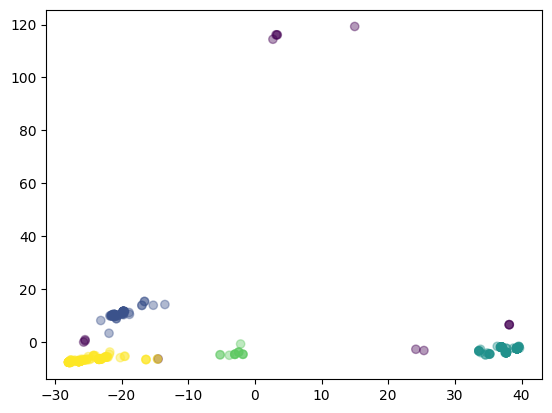

In [292]:
_ = plt.scatter(features_pca_2_test[:,0], features_pca_2_test[:,1], alpha=.4, c=y_pred)

In [283]:
(y_pred==5).sum(), y_pred

(0,
 array([1, 0, 0, 4, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 1,
        3, 3, 3, 3, 0, 0, 0, 3, 1, 3, 0, 1, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1,
        1, 0, 3, 3, 3, 1, 3, 0, 0, 0, 3, 1, 3, 1, 4, 1, 3, 0, 3, 3, 1, 0,
        3, 1, 0, 0, 3, 0, 0, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3,
        0, 0, 0, 3, 0, 1, 3, 3, 1, 3, 4, 3, 0, 3, 0, 1, 1, 0, 1, 0, 0, 3,
        3, 1, 0, 3, 4, 1, 3, 2, 0, 3, 1, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 1,
        0, 3, 0, 4, 3, 0, 4, 3, 4, 4, 1, 3, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0,
        3, 0, 1, 0, 3, 3, 0, 0, 0, 3, 1, 0, 3, 4, 3, 0, 1, 1, 0, 3, 0, 1,
        1, 3, 0, 0, 1, 0, 3, 3, 0, 1, 1, 3, 0, 0, 3, 4, 2, 1, 0, 3, 3, 3,
        0, 3, 3, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 1, 0,
        1, 3, 3, 0, 1, 0, 0, 4, 0, 3, 3, 4, 1, 0, 3, 2, 0, 3, 1, 0, 1, 0,
        0, 0, 3, 3, 0, 0, 1, 3, 3, 3, 1, 0, 0, 3, 3, 3, 1, 3, 1, 0, 3, 0,
        0, 1, 3, 2, 3, 0, 1, 0, 3, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 4,
        0, 1, 3, 1, 0, 0, 3, 3, 0,